# Flax-pilot Trainer with pre-trained models


**Use TensorFlow-cpu instead of TensorFlow to avoid any issues between TensorFlow & Jax.**

In [1]:
!pip install -q tensorflow-cpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.3.2 which is incompatible.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.16.2 which is incompatible.


In [2]:
!pip install -q mergedeep

In [3]:
import jax
import optax
import functools
import tensorflow as tf
import flax.linen as nn
import jax.numpy as jnp
import jax.random as jr
from mergedeep import merge as dmerge

In [4]:
import jax, flax, orbax.checkpoint
jax.__version__, flax.__version__, orbax.checkpoint.__version__

('0.4.26', '0.8.4', '0.5.15')

In [5]:
import os
os.listdir("/kaggle/input/fpilot")

['trackers', 'checkpoints', 'opt_utils', 'training']

In [6]:
import glob, sys
sys.path.append("/kaggle/input")

**Refer to the `mnist-class` and `mnist-vae` for single optimizing without frozen pre-trained and refer to `mnist-vae-gan-cfg` for multi-optimization without pre-trained and use this notebook for single & multi optimization with frozen pre-trained layers.**

## Single-optimization with Frozen pre-trained

### First let's create a pre-trained classifier model on MNIST dataset and later we can use the trained backbone of that model for finetuning.

**BackBone for pre-training**<br>
Once trained, we can use the trained backbone weights for other finetuning tasks

In [7]:
class BackBone(nn.Module):
    @nn.compact
    def __call__(self, x, deterministic):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        return x

**Feed forward layer**<br>
A feed forward classifier

In [8]:
class FeedForward(nn.Module):
    num_classes: int
        
    @nn.compact
    def __call__(self, x, deterministic):
        x = x.reshape(x.shape[0], -1)
        x = nn.Dense(features=256)(x)
        x = nn.Dropout(rate=0.3, deterministic=deterministic)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.num_classes)(x)
        return x

**Encapsulate both the backbone and classifier**

In [9]:
class Classifier(nn.Module):
    
    def setup(self, ):
        self.base = BackBone()
        self.ff = FeedForward(10)
    
    @nn.compact
    def __call__(self, x, deterministic):
        return self.ff(self.base(x, deterministic), deterministic)

**Load the data**

In [10]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(256).batch(128, True)
train_ds = train_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255, tf.one_hot(y, 10)), num_parallel_calls=tf.data.AUTOTUNE)

# Second batching for distributing with pmap.
train_ds = train_ds.batch(2, True)
train_ds = train_ds.repeat().as_numpy_iterator()

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.shuffle(256).batch(128, True)
val_ds = val_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255, tf.one_hot(y, 10)), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(2, True)
val_ds = val_ds.repeat().as_numpy_iterator()

train_ds, val_ds

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x79580b632e60>),
 NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7958043c0520>))

**Loss metric function**

In [11]:
def loss_fn(params, apply, sample, deterministic, global_key, step):
    x, y = sample
    yp = apply(params, x, deterministic=deterministic, rngs={'dropout': global_key})
    loss = optax.softmax_cross_entropy(yp, y).mean()
    yp = nn.softmax(yp, axis=-1)
    loss_metric_values_dict = {
        'lt': {'loss': loss},
        'mt': {'f1': (y, yp), 'acc': (y, yp), 'pre': (y, yp), 'rec': (y, yp)}
    }
    return loss, loss_metric_values_dict

**Loss metric dict**

In [12]:
import fpilot.trackers.basic_trackers as tr

trackers = {
        'lt': {'loss': tr.Mean()},
        'mt':{'f1': tr.F1Score(num_classes=10, threshold=0.7, average='macro'), 'acc': tr.Accuracy(),
              'pre': tr.Precision(num_classes=10, threshold=0.7, average='micro'),
              'rec': tr.Recall(num_classes=10, threshold=0.7, average='macro')
             }
}

In [13]:
from fpilot.training.trainer import Trainer
pre_trainer = Trainer(Classifier(), {'x': (1, 28, 28, 1)}, optax.adam(0.001), loss_fn, trackers, True)

**Train**

In [16]:
pre_trainer.train(10, train_ds, val_ds, 60000//256, 10000//256, "/kaggle/working/pre-trained-models/mnist", 3)

Epoch 1: 100%|██████████| 234/234 [00:04<00:00, 55.67it/s] 


Train:  loss: 0.29870272, acc: 0.9110577, f1: 0.8909324, pre: 0.972978, rec: 0.8234481, time: 4.207083702087402
Val:  loss: 0.08674152, acc: 0.9717548, f1: 0.9693476, pre: 0.98632383, rec: 0.9532285, time: 0.07775640487670898


Epoch 2: 100%|██████████| 234/234 [00:00<00:00, 422.54it/s]


Train:  loss: 0.08307776, acc: 0.9743924, f1: 0.97094345, pre: 0.988876, rec: 0.9538557, time: 0.5564565658569336
Val:  loss: 0.04964918, acc: 0.9825721, f1: 0.97992325, pre: 0.99179554, rec: 0.9683992, time: 0.07416725158691406


Epoch 3: 100%|██████████| 234/234 [00:00<00:00, 417.26it/s]


Train:  loss: 0.058012567, acc: 0.982472, f1: 0.9796104, pre: 0.9913199, rec: 0.9682577, time: 0.5640852451324463
Val:  loss: 0.038534038, acc: 0.9873798, f1: 0.9845201, pre: 0.9937786, rec: 0.9755414, time: 0.07535028457641602


Epoch 4: 100%|██████████| 234/234 [00:00<00:00, 416.29it/s]


Train:  loss: 0.04545213, acc: 0.98577726, f1: 0.9833507, pre: 0.99320734, rec: 0.97375804, time: 0.5651957988739014
Val:  loss: 0.035026595, acc: 0.98778045, f1: 0.9857755, pre: 0.9936912, rec: 0.97813386, time: 0.07505607604980469


Epoch 5: 100%|██████████| 234/234 [00:00<00:00, 423.60it/s]


Train:  loss: 0.03548679, acc: 0.9894165, f1: 0.9871651, pre: 0.99454534, rec: 0.9799312, time: 0.5549752712249756
Val:  loss: 0.03130479, acc: 0.9883814, f1: 0.987813, pre: 0.9949222, rec: 0.98093027, time: 0.07576704025268555


Epoch 6: 100%|██████████| 234/234 [00:00<00:00, 417.27it/s]


Train:  loss: 0.0308945, acc: 0.99020106, f1: 0.98890764, pre: 0.99503195, rec: 0.9828834, time: 0.5637850761413574
Val:  loss: 0.027278438, acc: 0.9900842, f1: 0.989511, pre: 0.9949387, rec: 0.9842353, time: 0.07170319557189941


Epoch 7: 100%|██████████| 234/234 [00:00<00:00, 418.12it/s]


Train:  loss: 0.027434774, acc: 0.99145305, f1: 0.9900274, pre: 0.9955276, rec: 0.984612, time: 0.5623199939727783
Val:  loss: 0.027395254, acc: 0.99098563, f1: 0.9896488, pre: 0.99574184, rec: 0.98372215, time: 0.07420206069946289


Epoch 8: 100%|██████████| 234/234 [00:00<00:00, 404.28it/s]


Train:  loss: 0.024011945, acc: 0.99270505, f1: 0.99138653, pre: 0.9962243, rec: 0.98659414, time: 0.5822081565856934
Val:  loss: 0.02856163, acc: 0.9906851, f1: 0.989697, pre: 0.99404, rec: 0.98551226, time: 0.07369422912597656


Epoch 9: 100%|██████████| 234/234 [00:00<00:00, 393.32it/s]


Train:  loss: 0.020637974, acc: 0.99327266, f1: 0.9925253, pre: 0.99670076, rec: 0.9883685, time: 0.5983450412750244
Val:  loss: 0.025505848, acc: 0.99108577, f1: 0.9906459, pre: 0.99464834, rec: 0.98679477, time: 0.07366657257080078


Epoch 10: 100%|██████████| 234/234 [00:00<00:00, 411.32it/s]


Train:  loss: 0.019300967, acc: 0.9937568, f1: 0.9927832, pre: 0.9966859, rec: 0.98891824, time: 0.571467399597168
Val:  loss: 0.026704215, acc: 0.9906851, f1: 0.9902403, pre: 0.9948461, rec: 0.9858386, time: 0.07638669013977051


In [15]:
pre_trainer.evaluate(val_ds, 10000//256)

Val:  loss: 0.026805371, acc: 0.99098563, f1: 0.9904445, pre: 0.9950474, rec: 0.98596853, time: 1.6183476448059082


**Save the checkpoint**

In [80]:
# args: location to save checkpoint
pre_trainer.save_state('/kaggle/working/pre-trained-models/manual_mnist_save2')

State saved..


**Check results**

In [16]:
sample = next(val_ds)
x, y = sample[0][:, :8], sample[1][:, :8]

rngs = {} # no rng needed bcz prediction doesnt require dropout
tensor_inputs = {'x': x}

yp = pre_trainer(rngs, tensor_inputs, deterministic=True)
yp = nn.softmax(yp, axis=-1).argmax(axis=-1)

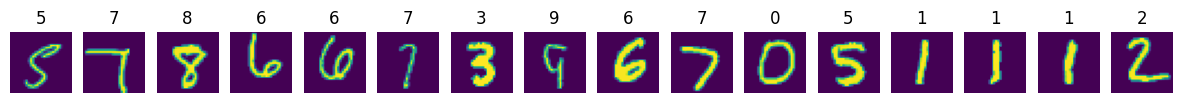

In [17]:
import matplotlib.pyplot as plt

yp = yp.reshape(16, -1)
x = x.reshape(16, 28, 28, 1)

plot_images = iter(x)
labels = iter(yp)
fig, ax = plt.subplots(1, 16, figsize=(15, 15))

for i in range(16):
        ax[i].imshow(next(plot_images))
        ax[i].set_title(str(next(labels)[0]))
        ax[i].axis('off')

### Fine-tuning

**Lets use the backbone params for other tasks. In this example lets use the trained backbone for Encoder part of VAE**


**Extract the params of backbone**

In [18]:
temp_ckpt = orbax.checkpoint.PyTreeCheckpointer()
classifier_state = temp_ckpt.restore("/kaggle/working/pre-trained-models/manual_mnist_save2/2340/default")
base_params = classifier_state['params']['params']['base']

/opt/conda/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1401: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


**VAE Model**

**Lets use the backbone in the encoder.**

In [19]:
class Encoder(nn.Module):
    base: nn.Module = BackBone()
    
    def setup(self,):
        self.ff = nn.Sequential([
            nn.Dense(16),
            nn.relu,
            nn.Dense(4)
        ])
    
        
    def __call__(self, x, deterministic):
        x = self.base(x, deterministic)
        x = x.reshape(x.shape[0], -1)
        x = self.ff(x)
        mean, logvar = jnp.split(x, 2, -1)
        return mean, logvar
    
    
class Decoder(nn.Module):    
    @nn.compact
    def __call__(self, z):
        y = nn.relu(nn.Dense(49*64)(z))
        y = y.reshape(y.shape[0], 7, 7, 64)
        y = nn.relu(nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y = nn.relu(nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y = nn.ConvTranspose(features=1, kernel_size=(3, 3), padding='SAME')(y)
        y = nn.sigmoid(y)
        return y
        
        
class VAE(nn.Module):
    encoder: nn.Module = Encoder()
    decoder: nn.Module = Decoder()
    
    # Must have 'deterministic param'.
    @nn.compact
    def __call__(self, x, deterministic):
        mean, logvar = self.encode(x, deterministic)
        z = self.reparam_trick(mean, logvar)
        y = self.decode(z)
        return (mean, logvar), y
        
    def encode(self, x, deterministic):
        return self.encoder(x, deterministic)
    
    def decode(self, x):
        return self.decoder(x)
    
    def reparam_trick(self, mean, logvar):
        e = jr.normal(self.make_rng('normal'), mean.shape)
        return mean + jnp.exp(0.5*logvar)*e

**Loss function for VAE**

In [20]:
def loss_fn(params, apply, sample, deterministic, global_key, step):
    x, _ = sample
    (mean, logvar), y = apply(params, x, deterministic=deterministic, rngs={'normal': global_key})
    
    recons_loss = -(x*jnp.log(y+0.00001) + (1-x)*jnp.log(1-y+0.00001)).sum(axis=(1, 2)).mean()
    kl_loss = (-0.5 * (1 + logvar - jnp.square(mean) - jnp.exp(logvar))).sum(axis=(1, )).mean()
    loss = recons_loss + kl_loss
    loss_metric_values_dict = { 
        'lt': {'kl_loss': kl_loss.mean(), 'recons_loss': recons_loss.mean()},
        'mt': dict()
        }
    return loss, loss_metric_values_dict

**Trackers for VAE**

In [21]:
import fpilot.trackers.basic_trackers as tr

trackers = {
        'lt': {'kl_loss': tr.Mean(), 'recons_loss': tr.Mean()},
        'mt':{}
}

**Create optimizer mask**

In [22]:
mask = {
    'params': # first key `params` is default for any mask. 
        {
            'encoder': {
                'base': False,
                'ff': True
            },
            'decoder': True
        }
}

**Initiate trainer**

In [38]:
vae_trainer = Trainer(VAE(), 
                      {'x': (1, 28, 28, 1)}, 
                       optax.adam(0.0001), 
                       loss_fn, 
                       trackers,
                       mask)

**Set the params of Backbone to its pre-trained weights**<br>
Check the docstring of the function for explaination

In [39]:
replacement_path = [
    ['params', 'encoder', 'base']
]
replacement_params = [
    base_params
]
vae_trainer.transfer_params(replacement_path, replacement_params)

**Lets check if the weights are transferred**

In [40]:
pre_base_params = pre_trainer.state.params['params']['base']
vae_base_params = vae_trainer.state.params['params']['encoder']['base']
results = jax.tree_util.tree_map(lambda x, y: jnp.array_equal(x, y), pre_base_params, vae_base_params)
results

{'Conv_0': {'bias': Array(True, dtype=bool),
  'kernel': Array(True, dtype=bool)},
 'Conv_1': {'bias': Array(True, dtype=bool),
  'kernel': Array(True, dtype=bool)}}

**Train the VAE**

In [45]:
vae_trainer.train(30, train_ds, val_ds, 60000//256, 10000//256, '/kaggle/working/pilot-examples/vae_v2', 3)

Epoch 1: 100%|██████████| 234/234 [00:01<00:00, 173.17it/s]


Train:  kl_loss: 6.3119526, recons_loss: 151.13234, time: 1.3542017936706543
Val:  kl_loss: 6.3089943, recons_loss: 151.16647, time: 0.07786345481872559
State saved..


Epoch 2: 100%|██████████| 234/234 [00:01<00:00, 185.90it/s]


Train:  kl_loss: 6.3334846, recons_loss: 150.89444, time: 1.2623608112335205
Val:  kl_loss: 6.345585, recons_loss: 151.32675, time: 0.08568668365478516
State saved..


Epoch 3: 100%|██████████| 234/234 [00:01<00:00, 185.46it/s]


Train:  kl_loss: 6.3260593, recons_loss: 150.7251, time: 1.2645649909973145
Val:  kl_loss: 6.3343306, recons_loss: 151.07275, time: 0.07820653915405273
State saved..


Epoch 4: 100%|██████████| 234/234 [00:01<00:00, 185.75it/s]


Train:  kl_loss: 6.3427095, recons_loss: 150.5261, time: 1.2626714706420898
Val:  kl_loss: 6.3504243, recons_loss: 150.6063, time: 0.07920503616333008
State saved..


Epoch 5: 100%|██████████| 234/234 [00:01<00:00, 185.43it/s]


Train:  kl_loss: 6.3569555, recons_loss: 150.2955, time: 1.2649497985839844
Val:  kl_loss: 6.349123, recons_loss: 150.52313, time: 0.08509206771850586
State saved..


Epoch 6: 100%|██████████| 234/234 [00:01<00:00, 185.05it/s]


Train:  kl_loss: 6.366825, recons_loss: 150.10992, time: 1.2675120830535889
Val:  kl_loss: 6.3634706, recons_loss: 150.24005, time: 0.08472394943237305
State saved..


Epoch 7: 100%|██████████| 234/234 [00:01<00:00, 184.97it/s]


Train:  kl_loss: 6.3726225, recons_loss: 149.8978, time: 1.2684004306793213
Val:  kl_loss: 6.3873606, recons_loss: 150.1672, time: 0.09701180458068848
State saved..


Epoch 8: 100%|██████████| 234/234 [00:01<00:00, 184.85it/s]


Train:  kl_loss: 6.3881536, recons_loss: 149.73975, time: 1.2689208984375
Val:  kl_loss: 6.377781, recons_loss: 149.87369, time: 0.07743334770202637
State saved..


Epoch 9: 100%|██████████| 234/234 [00:01<00:00, 184.77it/s]


Train:  kl_loss: 6.402017, recons_loss: 149.5863, time: 1.2692389488220215
Val:  kl_loss: 6.411751, recons_loss: 149.7448, time: 0.08582782745361328
State saved..


Epoch 10: 100%|██████████| 234/234 [00:01<00:00, 184.61it/s]


Train:  kl_loss: 6.400445, recons_loss: 149.33826, time: 1.2704362869262695
Val:  kl_loss: 6.4018335, recons_loss: 149.61598, time: 0.08276963233947754
State saved..


Epoch 11: 100%|██████████| 234/234 [00:01<00:00, 184.65it/s]


Train:  kl_loss: 6.4220886, recons_loss: 149.15622, time: 1.2702484130859375
Val:  kl_loss: 6.395706, recons_loss: 149.67766, time: 0.07903599739074707
State saved..


Epoch 12: 100%|██████████| 234/234 [00:01<00:00, 184.15it/s]


Train:  kl_loss: 6.4240675, recons_loss: 148.98709, time: 1.27358078956604
Val:  kl_loss: 6.410967, recons_loss: 149.2764, time: 0.08208584785461426
State saved..


Epoch 13: 100%|██████████| 234/234 [00:01<00:00, 183.94it/s]


Train:  kl_loss: 6.4368863, recons_loss: 148.85141, time: 1.2749862670898438
Val:  kl_loss: 6.427857, recons_loss: 149.22873, time: 0.08317708969116211
State saved..


Epoch 14: 100%|██████████| 234/234 [00:01<00:00, 184.16it/s]


Train:  kl_loss: 6.4352474, recons_loss: 148.7261, time: 1.2738044261932373
Val:  kl_loss: 6.429202, recons_loss: 148.97054, time: 0.07785987854003906
State saved..


Epoch 15: 100%|██████████| 234/234 [00:01<00:00, 183.85it/s]


Train:  kl_loss: 6.445553, recons_loss: 148.48877, time: 1.275510311126709
Val:  kl_loss: 6.453039, recons_loss: 148.68417, time: 0.08302831649780273
State saved..


Epoch 16: 100%|██████████| 234/234 [00:01<00:00, 183.95it/s]


Train:  kl_loss: 6.458065, recons_loss: 148.38113, time: 1.274867057800293
Val:  kl_loss: 6.449472, recons_loss: 148.92096, time: 0.08060693740844727
State saved..


Epoch 17: 100%|██████████| 234/234 [00:01<00:00, 183.79it/s]


Train:  kl_loss: 6.4506745, recons_loss: 148.20515, time: 1.276078701019287
Val:  kl_loss: 6.4443445, recons_loss: 148.52876, time: 0.07904696464538574
State saved..


Epoch 18: 100%|██████████| 234/234 [00:01<00:00, 183.24it/s]


Train:  kl_loss: 6.4647045, recons_loss: 148.0834, time: 1.2797038555145264
Val:  kl_loss: 6.4616804, recons_loss: 148.45844, time: 0.07785916328430176
State saved..


Epoch 19: 100%|██████████| 234/234 [00:01<00:00, 183.18it/s]


Train:  kl_loss: 6.471648, recons_loss: 147.94043, time: 1.280599594116211
Val:  kl_loss: 6.4556265, recons_loss: 148.45605, time: 0.07748246192932129
State saved..


Epoch 20: 100%|██████████| 234/234 [00:01<00:00, 183.38it/s]


Train:  kl_loss: 6.480275, recons_loss: 147.78494, time: 1.278803825378418
Val:  kl_loss: 6.458597, recons_loss: 148.24564, time: 0.08380818367004395
State saved..


Epoch 21: 100%|██████████| 234/234 [00:01<00:00, 183.17it/s]


Train:  kl_loss: 6.491499, recons_loss: 147.60707, time: 1.2806119918823242
Val:  kl_loss: 6.4674377, recons_loss: 148.16853, time: 0.07735109329223633
State saved..


Epoch 22: 100%|██████████| 234/234 [00:01<00:00, 183.27it/s]


Train:  kl_loss: 6.490141, recons_loss: 147.52234, time: 1.2798922061920166
Val:  kl_loss: 6.492318, recons_loss: 148.00478, time: 0.07993412017822266
State saved..


Epoch 23: 100%|██████████| 234/234 [00:01<00:00, 182.75it/s]


Train:  kl_loss: 6.496785, recons_loss: 147.36737, time: 1.2833902835845947
Val:  kl_loss: 6.4637213, recons_loss: 147.7576, time: 0.08141875267028809
State saved..


Epoch 24: 100%|██████████| 234/234 [00:01<00:00, 182.82it/s]


Train:  kl_loss: 6.500552, recons_loss: 147.30142, time: 1.2835862636566162
Val:  kl_loss: 6.5185337, recons_loss: 147.62231, time: 0.09444665908813477
State saved..


Epoch 25: 100%|██████████| 234/234 [00:01<00:00, 182.64it/s]


Train:  kl_loss: 6.526451, recons_loss: 147.17157, time: 1.2841086387634277
Val:  kl_loss: 6.5107803, recons_loss: 147.59839, time: 0.07918024063110352
State saved..


Epoch 26: 100%|██████████| 234/234 [00:01<00:00, 182.58it/s]


Train:  kl_loss: 6.5198755, recons_loss: 147.04251, time: 1.2845544815063477
Val:  kl_loss: 6.482708, recons_loss: 147.56525, time: 0.08471488952636719
State saved..


Epoch 27: 100%|██████████| 234/234 [00:01<00:00, 182.73it/s]


Train:  kl_loss: 6.5268364, recons_loss: 146.91818, time: 1.2836389541625977
Val:  kl_loss: 6.5096264, recons_loss: 147.40614, time: 0.07789993286132812
State saved..


Epoch 28: 100%|██████████| 234/234 [00:01<00:00, 182.89it/s]


Train:  kl_loss: 6.5378838, recons_loss: 146.80196, time: 1.2823853492736816
Val:  kl_loss: 6.530436, recons_loss: 147.3194, time: 0.07966160774230957
State saved..


Epoch 29: 100%|██████████| 234/234 [00:01<00:00, 182.35it/s]


Train:  kl_loss: 6.5319166, recons_loss: 146.64447, time: 1.2862539291381836
Val:  kl_loss: 6.520656, recons_loss: 147.2086, time: 0.07963728904724121
State saved..


Epoch 30: 100%|██████████| 234/234 [00:01<00:00, 182.55it/s]


Train:  kl_loss: 6.5390263, recons_loss: 146.56792, time: 1.2847585678100586
Val:  kl_loss: 6.512916, recons_loss: 147.22638, time: 0.08551478385925293
State saved..


**Lets check if weights have changed**

In [46]:
pre_base_params = pre_trainer.state.params['params']['base']
vae_base_params = vae_trainer.state.params['params']['encoder']['base']
results = jax.tree_util.tree_map(lambda x, y: jnp.array_equal(x, y), pre_base_params, vae_base_params)
results

{'Conv_0': {'bias': Array(True, dtype=bool),
  'kernel': Array(True, dtype=bool)},
 'Conv_1': {'bias': Array(True, dtype=bool),
  'kernel': Array(True, dtype=bool)}}

The above output shows that the weights of the backbone haven't changed during VAE training ensuring frozen weights

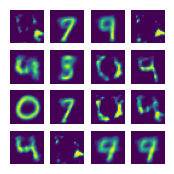

In [49]:
rand = jr.normal(jr.PRNGKey(102), (2, 8, 2))

rngs = {'normal': jax.random.PRNGKey(13)}
tensor_inputs = {'x': rand}

output = vae_trainer(rngs, tensor_inputs, method='decode')

plot_images = iter(output.reshape(16, 28, 28, 1))
fig, ax = plt.subplots(4, 4, figsize=(2, 2))

for x in range(4):
    for y in range(4):
        ax[x, y].imshow(next(plot_images))
        ax[x, y].axis('off')

Further training will lead to better results.

### Multi-optimization using pre-trained models.

**Accessible [here](https://github.com/NITHISHM2410/flax-pilot/blob/main/examples/vae-gan-cfg-using-pretrained.ipynb)**